<center><img src="https://www.freewebheaders.com/wp-content/gallery/drinks/awesome-wine-barrel-and-bottle-with-red-wine-glasses-web-header.jpg" width=800 /></center>

# Project Goal

> Find drivers of wine quality and create a model that can accurately predict wine quality while performing better than baseline.

# Project Description

> Using the dataset for wine quality from [Data World](https://data.world/food/wine-quality), we looked for physicochemical properties that might have an effect on wine quality.

# Initial Hypotheses

> We believe that density, pH, alcohol, and sulphates will be the best predictors of wine quality.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import wrangle as w

import warnings
warnings.filterwarnings("ignore")

# Acquire

* Data acquired from Data World
* Combined both csv's and added additional column to include wine_type
* Cached combined file to local csv
* Each row represents a unique wine sample, its physicochemical properties, and its quality

In [2]:
wines = pd.read_csv('wines.csv')

In [3]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


# Prepare

* Visualized full dataset for univariate exploration
    * Histograms showed normal distributions
    * Handled outliers by removing top 1% of values in each column
* Created new column (quality_bin) for target variable:
    * **Bad = 3-5**
    * **Good = 6-9**
* Verified datatypes
* Corrected column names
* Checked for nulls (there were none)
* Split the data, stratifying on quality_bin

In [4]:
wines = w.prepare_data(wines)

wines.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,good
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,good
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,good
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,good
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,good


In [6]:
train, validate, test = w.split_data(wines, 'quality_bin')

In [7]:
#Pulse check

train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin
2614,6.15,0.21,0.37,3.2,0.021,20.0,80.0,0.99076,3.39,0.47,12.0,5,white,bad
671,6.60,0.28,0.36,1.7,0.038,22.0,101.0,0.99120,3.29,0.57,11.6,6,white,good
4746,6.30,0.23,0.50,10.4,0.043,61.0,132.0,0.99542,2.86,0.46,9.1,6,white,good
2647,5.80,0.15,0.28,0.8,0.037,43.0,127.0,0.99198,3.24,0.51,9.3,5,white,bad
4867,5.30,0.60,0.34,1.4,0.031,3.0,60.0,0.98854,3.27,0.38,13.0,6,white,good


## Explore

### Exploring effect of selected four variables to quality

On our second iteration, we checked for correlations of all numeric variables against the continuous version of the quality target variable.

### Bivariate Exploration

Here, we isolated the features from the pairplot with the highest correlations to wine quality.

$H_0$: There is no correlation between our selected features (density, pH, alcohol, sulphates) and our target variable (quality).

$H_\alpha$: There is a correlation between our selected features and our target variable (quality).

$\alpha$: 0.05

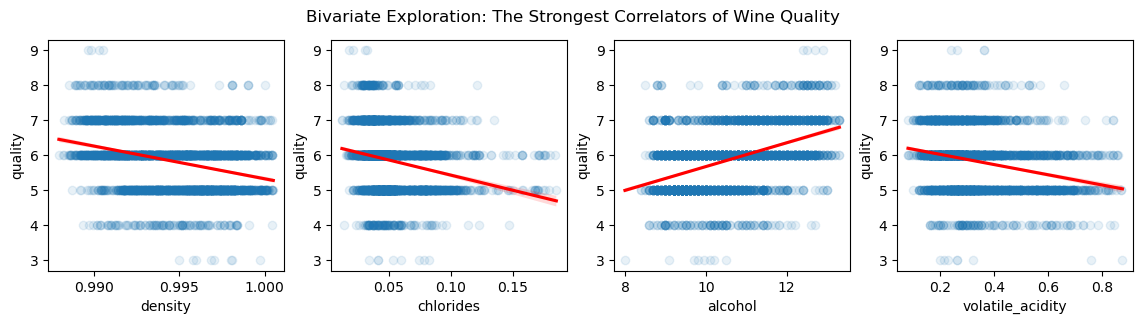

In [120]:
plt.figure(figsize=(14,3))
plt.suptitle('Bivariate Exploration: The Strongest Correlators of Wine Quality')
for i, col in enumerate(train[['density', 'chlorides', 'alcohol', 'volatile_acidity', 'quality']]):
    if col != 'quality':
        plt.subplot(1, 4, i+1)
        sns.regplot(data = train, x = col, y = 'quality', scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})

plt.show()

Running Pearson's Test to verify correlation and p-values.

In [9]:
corr_df = w.correlation_tests(train[['density', 'chlorides', 'alcohol', 'volatile_acidity', 'wine_type', 'quality']])

corr_df

,feature,r,p
4,quality,1.000000,0.000000e+00
2,alcohol,0.453331,4.252438e-178
0,density,0.307832,3.490146e-78
3,volatile_acidity,0.253654,7.762193e-53
1,chlorides,0.238127,1.349135e-46


This confirms that the correlation coefficients of all the selected features were not just due to chance.

Among all twelve features, alcohol, density, volatile_acidity, and chlorides had the highest correlation with wine quality. We will keep that in mind as we move into exploring clusters (multivariate exploration).

### Multivariate Exploration

We created visualizations using all combinations of the above mentioned variables against the binned target variable.

Of all visualizations, the below three stood out to us the most.

**TO DO**

Function for below block.

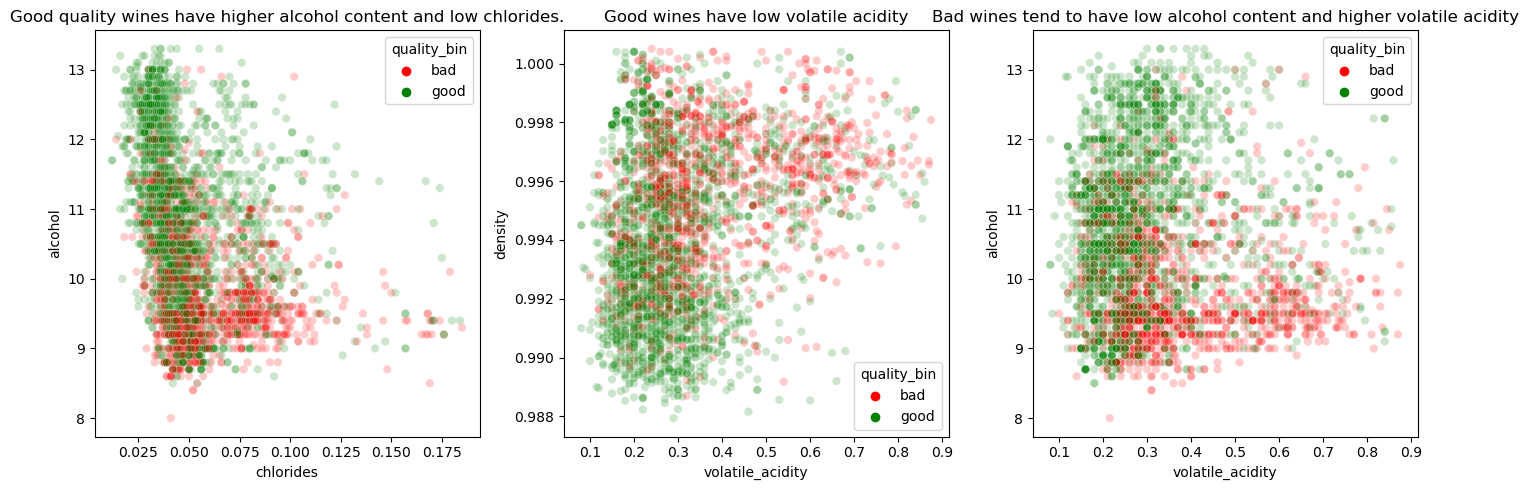

In [51]:
c_list = ['red', 'green']

plt.figure(figsize=(14,5))

plt.subplot(131)
sns.scatterplot(data=train, x='chlorides', y='alcohol', hue='quality_bin', palette=c_list, alpha=0.2)
plt.title('Good quality wines have higher alcohol content and low chlorides.')

plt.subplot(132)
sns.scatterplot(data=train, x='volatile_acidity', y='density', hue='quality_bin', palette=c_list, alpha=0.2)
plt.title('Good wines have low volatile acidity')

plt.subplot(133)
sns.scatterplot(data=train, x='volatile_acidity', y='alcohol', hue='quality_bin', palette=c_list, alpha=0.2)
plt.title('Bad wines tend to have low alcohol content and higher volatile acidity')

plt.tight_layout()
plt.show()

Scaling selected features to send into clustering

In [52]:
train_scaled, validate_scaled, test_scaled =  w.scale_data(train, validate, test, 
        cols=train.iloc[:, 0:11].columns)

train_scaled[['density', 'chlorides', 'volatile_acidity', 'alcohol', 'quality_bin']].head()

,density,chlorides,volatile_acidity,alcohol,quality_bin
2614,0.224522,0.052023,0.163522,0.754717,bad
671,0.259554,0.150289,0.251572,0.679245,good
4746,0.595541,0.179191,0.188679,0.207547,good
2647,0.321656,0.144509,0.088050,0.245283,bad
4867,0.047771,0.109827,0.654088,0.943396,good


**TO DO**

The following two blocks should be in one function, but be adjustable for each combo. We will need to be able to input:

* The two features we're looking at
* The centroids (init argument)

Out put should just be the two side-by-side plots.

In [69]:
from sklearn.cluster import KMeans

X = train_scaled[['volatile_acidity', 'density']]

kmeans = KMeans(n_clusters=2
                , init = np.array([[0.0,0.6], [0.5,0.6]], np.float64)
                , max_iter=1
               )
kmeans.fit(X)
train_scaled['va_d'] = kmeans.predict(X)

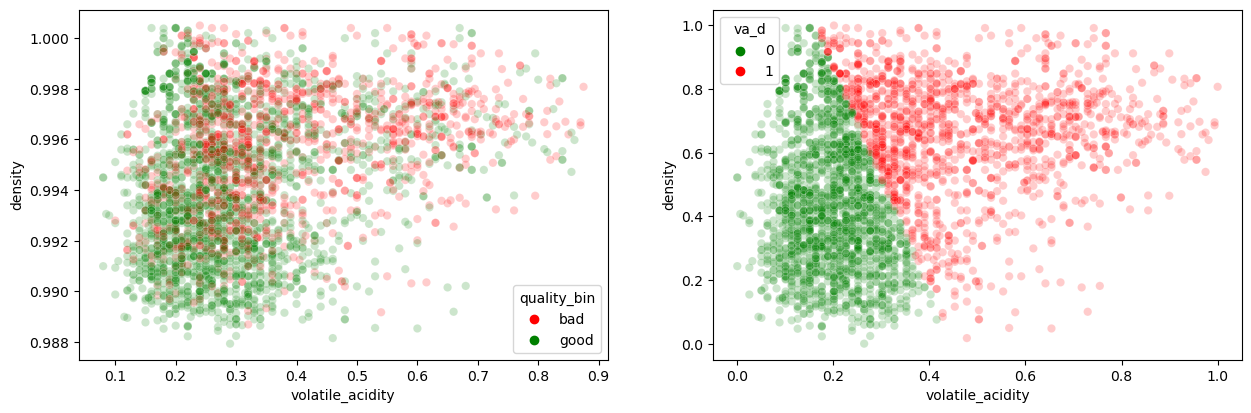

In [70]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
sns.scatterplot(data=train, x='volatile_acidity', y='density', hue='quality_bin', palette=c_list, alpha=0.2)

plt.subplot(2,2,2)
sns.scatterplot(data=train_scaled, x='volatile_acidity', y='density', hue='va_d', palette= ['green', 'red'], alpha=0.2)

plt.show()

In [100]:
X = train_scaled[['volatile_acidity', 'alcohol']]

kmeans = KMeans(n_clusters=2
                , init = np.array([[0.1,0.2], [0.3,0.175]], np.float64)
                , max_iter=1
               )
kmeans.fit(X)
train_scaled['va_a'] = kmeans.predict(X)

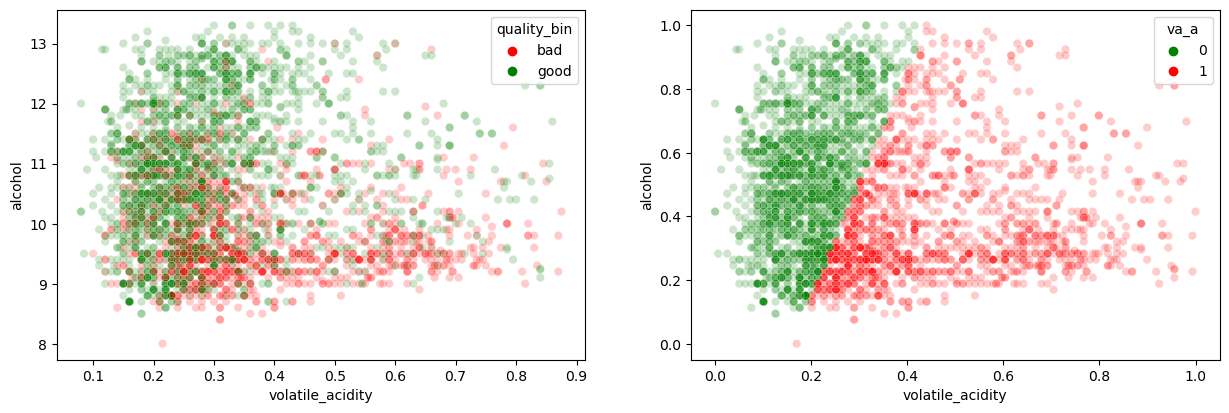

In [101]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
sns.scatterplot(data=train, x='volatile_acidity', y='alcohol', hue='quality_bin', palette=c_list, alpha=0.2)

plt.subplot(2,2,2)
sns.scatterplot(data=train_scaled, x='volatile_acidity', y='alcohol', hue='va_a', palette= ['green', 'red'], alpha=0.2)

plt.show()

In [107]:
from sklearn.cluster import KMeans

X = train_scaled[['chlorides', 'alcohol']]

kmeans = KMeans(n_clusters=2
                , init = np.array([[0.2,0.3], [0.2,0.2]], np.float64)
                , max_iter=1
               )
kmeans.fit(X)
train_scaled['c_a'] = kmeans.predict(X)
train_scaled

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin,va_d,va_a,c_a
2614,0.28125,0.163522,0.506849,0.148148,0.052023,0.253333,0.318777,0.224522,0.736264,0.301370,0.754717,5,white,bad,0,0,0
671,0.33750,0.251572,0.493151,0.062678,0.150289,0.280000,0.410480,0.259554,0.626374,0.438356,0.679245,6,white,good,0,0,0
4746,0.30000,0.188679,0.684932,0.558405,0.179191,0.800000,0.545852,0.595541,0.153846,0.287671,0.207547,6,white,good,0,0,1
2647,0.23750,0.088050,0.383562,0.011396,0.144509,0.560000,0.524017,0.321656,0.571429,0.356164,0.245283,5,white,bad,0,0,1
4867,0.17500,0.654088,0.465753,0.045584,0.109827,0.026667,0.231441,0.047771,0.604396,0.178082,0.943396,6,white,good,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,0.33750,0.301887,0.301370,0.917379,0.196532,0.493333,0.550218,0.792994,0.549451,0.575342,0.452830,6,white,good,1,1,0
1950,0.51250,0.213836,0.178082,0.945869,0.138728,0.640000,0.925764,0.928344,0.263736,0.287671,0.320755,5,white,bad,1,0,1
4681,0.21250,0.238994,0.506849,0.017094,0.075145,0.133333,0.183406,0.040605,0.626374,0.109589,0.962264,6,white,good,0,0,0
3429,0.40000,0.125786,0.534247,0.792023,0.225434,0.626667,0.650655,0.917994,0.692308,0.726027,0.207547,5,white,bad,0,0,1


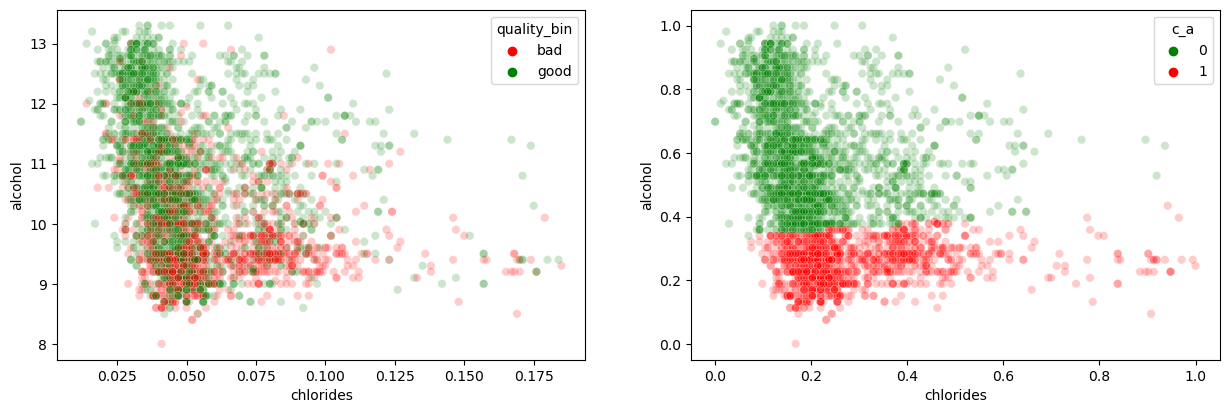

In [108]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
sns.scatterplot(data=train, x='chlorides', y='alcohol', hue='quality_bin', palette=c_list, alpha=0.2)

plt.subplot(2,2,2)
sns.scatterplot(data=train_scaled, x='chlorides', y='alcohol', hue='c_a', palette= ['green', 'red'], alpha=0.2)

plt.show()

$H_0$: There is no difference in the means of the clustered sets amongst each other for quality.

$H_\alpha$: There is a difference in the means of the clusters sets amongst each other for quality.

In [109]:
l_of_l = [['va_a', 'quality_bin'], ['va_d', 'quality_bin'], ['c_a', 'quality_bin']]

w.chi2_test(train_scaled, l_of_l)

,feature,chi2,p,degf,expected
1,"[va_a, quality_bin]",442.347606,3.338257e-98,1,"[[720.1970471323112, 1281.8029528676889], [546..."
2,"[va_d, quality_bin]",298.727676,6.236915e-67,1,"[[741.0618966496309, 1318.9381033503691], [525..."
3,"[c_a, quality_bin]",452.209171,2.384194e-100,1,"[[770.2007382169222, 1370.7992617830778], [496..."


Ran ANOVA tests on the three clusters towards target variable to select best clustering to send into our model.

The cluster with the lowest p-value was the volatile acidity and the alcohol combination. We will proceed with this cluster.

### Exploration Summary

* Predicting quality is predicted to be easier when separated into two bins of "good" vs. "bad" wines.
* Of all physicochemical properties, alcohol, density, volatile_acidity, and chlorides were the properties with the highest correlation with quality.
* Of the 55 graphs that we looked through, the features volatile_acidity, alcohol, density, and chlorides had the most prominent clusters.
* Of the 3 graphs that we proceeded with, the combination of alcohol and volatile acidity had the best accuracy of good vs. bad wines.
* We will proceed with feeding the cluster of alcohol + volatile_acidity into the model, as well as the independent variables of density and chlorides.

## Modeling

### Scaling on selected features

In [110]:
train_scaled, validate_scaled, test_scaled = w.get_cluster_columns(train_scaled, validate_scaled, test_scaled, 
                                                                   features_list = [['chlorides', 'alcohol']]
                      , clusters=2
                     , init_array = np.array([[0.2,0.3], [0.2,0.2]], np.float64)
                     , iterations = 1)

In [111]:
train_scaled.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin,va_d,va_a,c_a,chlorides_alcohol
2614,0.28125,0.163522,0.506849,0.148148,0.052023,0.253333,0.318777,0.224522,0.736264,0.301370,0.754717,5,white,bad,0,0,0,0
671,0.33750,0.251572,0.493151,0.062678,0.150289,0.280000,0.410480,0.259554,0.626374,0.438356,0.679245,6,white,good,0,0,0,0
4746,0.30000,0.188679,0.684932,0.558405,0.179191,0.800000,0.545852,0.595541,0.153846,0.287671,0.207547,6,white,good,0,0,1,1
2647,0.23750,0.088050,0.383562,0.011396,0.144509,0.560000,0.524017,0.321656,0.571429,0.356164,0.245283,5,white,bad,0,0,1,1
4867,0.17500,0.654088,0.465753,0.045584,0.109827,0.026667,0.231441,0.047771,0.604396,0.178082,0.943396,6,white,good,1,1,0,0


***TO DO*** (never mind, this is mvp_info)

Function for splitting TVT into X and y.

In [112]:
features = ['chlorides_alcohol', 'volatile_acidity', 'density']

X_train = train_scaled[features]
y_train = train_scaled.quality_bin

X_validate = validate_scaled[features]
y_validate = validate_scaled.quality_bin

X_test = test_scaled[features]
y_test = test_scaled.quality_bin

**TO DO** 

Remove below individual create_ models and just have one final that combines all, which should create the df of metrics across all models and one final df that just has the score on test using the best model.

In [113]:
w.create_knn(X_train,y_train, X_validate, y_validate)

,model_train,train_predict,validate_predict,n_neighbors
0,knn,0.639977,0.639977,neighbors
1,KNeighborsClassifier,0.971323,0.715503,1
2,KNeighborsClassifier,0.852924,0.646508,2
3,KNeighborsClassifier,0.842135,0.693356,3
4,KNeighborsClassifier,0.801533,0.688245,4
5,KNeighborsClassifier,0.800398,0.695060,5
6,KNeighborsClassifier,0.781942,0.691652,6
7,KNeighborsClassifier,0.773992,0.705281,7
8,KNeighborsClassifier,0.770017,0.690801,8
9,KNeighborsClassifier,0.768030,0.709540,9


In [114]:
w.create_logistic_regression(X_train,y_train, X_validate, y_validate)

,model_train,train_predict,validate_predict,C
0,LogisticRegression,0.639977,0.639977,the_c
1,LogisticRegression,0.707836,0.714651,0.01
2,LogisticRegression,0.726008,0.735945,0.1
3,LogisticRegression,0.732822,0.732538,1
4,LogisticRegression,0.735094,0.734242,10
5,LogisticRegression,0.733958,0.735094,100
6,LogisticRegression,0.733958,0.735094,1000


In [115]:
df, test_df = w.create_random_forest(X_train,y_train, X_validate, y_validate, X_test, y_test)

df

,model_train,train_predict,validate_predict,max_depth
0,RandomForestClassifier,0.639977,0.639977,max_depth
1,RandomForestClassifier,0.695627,0.683986,1
2,RandomForestClassifier,0.742760,0.735945,2
3,RandomForestClassifier,0.746735,0.737649,3
4,RandomForestClassifier,0.748722,0.739353,4
5,RandomForestClassifier,0.751562,0.738501,5
6,RandomForestClassifier,0.761499,0.735094,6
7,RandomForestClassifier,0.773992,0.738501,7
8,RandomForestClassifier,0.785065,0.741056,8
9,RandomForestClassifier,0.806076,0.747871,9


In [116]:
w.create_descision_tree(X_train,y_train, X_validate, y_validate)

,model_train,train_predict,validate_predict,max_depth
0,DecisionTreeClassifier,0.639977,0.639977,max_depth
1,DecisionTreeClassifier,0.698467,0.703578,1
2,DecisionTreeClassifier,0.744463,0.738501,2
3,DecisionTreeClassifier,0.744463,0.738501,3
4,DecisionTreeClassifier,0.747019,0.741908,4
5,DecisionTreeClassifier,0.754685,0.745315,5
6,DecisionTreeClassifier,0.767178,0.735094,6
7,DecisionTreeClassifier,0.781090,0.741908,7
8,DecisionTreeClassifier,0.794151,0.742760,8
9,DecisionTreeClassifier,0.806076,0.732538,9


In [117]:
w.super_classification_model(X_train,y_train, X_validate, y_validate, the_c = 1)

,model_train,train_predict,validate_predict
0,baseline,0.639977,0.639977
1,KNeighborsClassifier,0.755253,0.728279
2,LogisticRegression,0.732822,0.732538
3,RandomForestClassifier,0.751562,0.738501
4,DecisionTreeClassifier,0.767178,0.735094


In [118]:
df

,model_train,train_predict,validate_predict,max_depth
0,RandomForestClassifier,0.639977,0.639977,max_depth
1,RandomForestClassifier,0.695627,0.683986,1
2,RandomForestClassifier,0.742760,0.735945,2
3,RandomForestClassifier,0.746735,0.737649,3
4,RandomForestClassifier,0.748722,0.739353,4
5,RandomForestClassifier,0.751562,0.738501,5
6,RandomForestClassifier,0.761499,0.735094,6
7,RandomForestClassifier,0.773992,0.738501,7
8,RandomForestClassifier,0.785065,0.741056,8
9,RandomForestClassifier,0.806076,0.747871,9


In [119]:
test_df

,model_train,baseline,max_depth
0,RandomForestClassifier,0.639977,max_depth
1,RandomForestClassifier,0.733617,5


### Modeling Summary

* Established baseline at: 63%
* Ran through four different models.
* Random Forest performed the best with an accuracy score of 73%

## Conclusion

* Our top model beat the baseline by around 10%.

# Next Steps

* Send in all features independently of each other.
* Compare that to clustered features' effect on models.
* Deeper dive into white vs. reds.